# Machine learning: training

Biologists are increasingly using acoustic recorders to study species of interest. Many bioacousticians want to determine the identity of the sounds they have recorded; a variety of manual and automated methods exist for this purpose. Automated methods can make it easier and faster to quickly predict which species or sounds are in one's recordings.

Using a process called machine learning, bioacousticians can create (or "train") algorithms that can predict the identities of species vocalizing in acoustic recordings. These algorithms, called classifiers, typically do not identify sounds using the recording alone. Instead, they use image recognition techniques to identify sounds in spectrograms created from short segments of audio.

This tutorial will guide you through the process of training a simple classifier for a single species. To download the tutorial as a Jupyter Notebook and run it on your own computer, click the "Edit on GitHub" button at the top right of the tutorial. You will have to [install OpenSoundscape](installation.html#installation) to use the tutorial.

First, use the following packages to create a machine learning classifier. First, from OpenSoundscape import the following three functions (`run_command`, `binary_train_valid_split`, and `train`) and three classes (`Audio`, `Spectrogram`, and `SingleTargetAudioDataset`).

In [1]:
from opensoundscape.audio import Audio
from opensoundscape.spectrogram import Spectrogram
from opensoundscape.datasets import SingleTargetAudioDataset

from opensoundscape.helpers import run_command
from opensoundscape.data_selection import binary_train_valid_split
from opensoundscape.torch.train import train

Import the following machine learning-related modules. OpenSoundscape uses PyTorch to do machine learning.

In [2]:
import torch
import torch.nn
import torch.optim
import torchvision.models

Lastly, use a few miscellaneous functions.

In [3]:
# For interacting with paths on the filesystem
import os.path
from pathlib import Path

# For working with dataframes, arrays, and plotting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# For handling output of the training function
import io
from contextlib import redirect_stdout

# debugging
from IPython.core.debugger import set_trace
import sys

### Inspect the data

The folder contains 2s long audio clips taken from an autonomous recording unit. It also contains a file `woodcock_labels.csv` which contains the names of each file and its corresponding label information, created using a program called [Specky](https://github.com/rhine3/specky).

Look at the contents of `woodcock_labels.csv`. First, load them into a `pandas` DataFrame called `labels`. Use `labels.shape` to see how many audio files there are.

In [4]:
labels = pd.read_csv(Path("./data/annotations.csv"))
labels.shape

(82, 6)

The above call to `labels.shape` showed that there were 29 rows and 3 columns in the loaded dataframe. Look at the `head()` of this dataframe to see the first 5 rows of its contents.

In [5]:
labels.head()

,FOLDER,IN FILE,CHANNEL,OFFSET,DURATION,MANUAL ID
0,./data/bird/,Xiphorhynchus-guttatus-271015.wav,0,0.714921,2.903810,1
1,./data/bird/,Myrmothera-campanisona-28131.wav,0,1.134150,2.649524,1
2,./data/bird/,Myrmothera-campanisona-28131.wav,0,4.196190,2.000000,1
3,./data/bird/,Myrmothera-campanisona-28131.wav,0,7.930952,3.809388,1
4,./data/bird/,Myrmothera-campanisona-28131.wav,0,13.080748,2.000000,1



Before splitting this dataframe into training and validation sets, prepend the name of the folder in front of the filename. This allows our computer program to find these files on the filesystem during the training process.

In [6]:
labels['IN FILE'] = labels['FOLDER'] + labels['IN FILE'].astype(str)
labels.head()

,FOLDER,IN FILE,CHANNEL,OFFSET,DURATION,MANUAL ID
0,./data/bird/,./data/bird/Xiphorhynchus-guttatus-271015.wav,0,0.714921,2.903810,1
1,./data/bird/,./data/bird/Myrmothera-campanisona-28131.wav,0,1.134150,2.649524,1
2,./data/bird/,./data/bird/Myrmothera-campanisona-28131.wav,0,4.196190,2.000000,1
3,./data/bird/,./data/bird/Myrmothera-campanisona-28131.wav,0,7.930952,3.809388,1
4,./data/bird/,./data/bird/Myrmothera-campanisona-28131.wav,0,13.080748,2.000000,1


Now, use OpenSoundscape's `Spectrogram` and `Audio` classes to take a look at these files. For more information on the use of these classes, see the [tutorial](audio_and_spectrogram.html).

The first row in the `labels` dataframe contains a file with the following labels: the American Woodcock is present (`"woodcock" = "present"` and it makes a "song" in the recording (`"sound_type" = "song"`). Get the filename for this recording.

In [7]:
filename0 = labels.iloc[0]['IN FILE']
filename0

'./data/bird/Xiphorhynchus-guttatus-271015.wav'

Create a spectrogram from this file. The high-contrast signal of an American Woodcock display sound ("peent") is visible about 0.6 seconds into the recording.

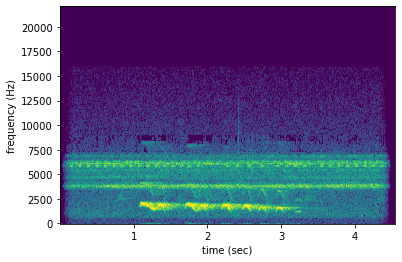

In [8]:
spect = Spectrogram.from_audio(Audio.from_file(filename0))
spect.plot()

The second file, which is marked as not having a woodcock in it (`"woodcock" = "absent"`), has no such signal:

In [9]:
filename1 = labels.iloc[-1]['IN FILE']
filename1

C:\Users\gppst\miniconda3\envs\E4Evenv\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'./data/nonbird/00KM53yZi2A_30.000.wav'

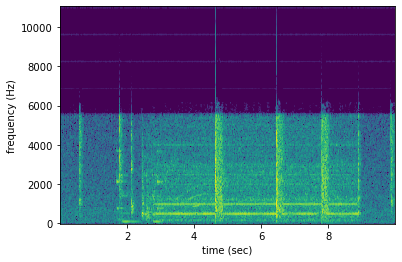

In [10]:
spect = Spectrogram.from_audio(Audio.from_file(filename1))
spect.plot()

In order to make it easier for future users to interpret the model results, save a dictionary that associates each numeric label with an explanatory string variable. In this case, mark the 0-labeled recordings `"scolopax-minor-absent"` and the 1-labeled recordings `"scolopax-minor-present"`. That way, as long as the model is bundled with this metadata, it will be easy to see that the `1` prediction corresponds to American Woodcock (scientific name *Scolopax minor*).

In [11]:
label_dict = {0:'bird-absent', 1:'bird-present'}

C:\Users\gppst\miniconda3\envs\E4Evenv\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Create machine learning datasets

### Training-validation split
Next, to use machine learning on these files, they must be separated into two datasets. The "training" dataset will be used to teach the machine learning algorithm. The "validation" dataset will be used to evaluate the algorithm's performance each epoch. The process of separating the data into multiple datasets is often known in machine learning as creating a "split."

Typically, machine learning practitioners use a separate validation set to check on the model's performance during and after training. While the training data are used to teach the model how to identify its focal species, the validation data are not used to teach the model. Instead, they are held out as a separate comparison. This allows us to check how well the model generalizes to data it has never seen before. A model that performs well on the training set, but very poorly on the validation set, is said to be *overfit*. Overfit models are great at identifying the original recordings they saw, but are often not useful for real applications.

First, look at the dataframe again.

In [12]:
labels.head()

,FOLDER,IN FILE,CHANNEL,OFFSET,DURATION,MANUAL ID
0,./data/bird/,./data/bird/Xiphorhynchus-guttatus-271015.wav,0,0.714921,2.903810,1
1,./data/bird/,./data/bird/Myrmothera-campanisona-28131.wav,0,1.134150,2.649524,1
2,./data/bird/,./data/bird/Myrmothera-campanisona-28131.wav,0,4.196190,2.000000,1
3,./data/bird/,./data/bird/Myrmothera-campanisona-28131.wav,0,7.930952,3.809388,1
4,./data/bird/,./data/bird/Myrmothera-campanisona-28131.wav,0,13.080748,2.000000,1


It's often desirable to make a *stratified split*. This means that the percentage of samples in the original dataset that have each label, will be roughly equal to the percentage of each label in the training and validation datasets. So, for instance, if half of the recordings in the original dataframe had the species present, in a stratified split, half of the recordings in the training dataframe and in the validation dataframe would have the species present. 

Use a scikit-learn function to do this, specifying the `"numeric_labels"` column as the one to stratify over.

In [13]:
train_df, valid_df = train_test_split(labels, train_size=0.8, stratify=labels['MANUAL ID'])

C:\Users\gppst\miniconda3\envs\E4Evenv\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Check that the dataframes are stratified correctly. Compare the fraction of positives in the original dataset with the fraction of positives in the training and validation subsets.

In [14]:
num_samples = labels.shape[0]
num_present = sum(labels['MANUAL ID'] == 1)
print(f"Fraction of original dataframe with bird present: {num_present/num_samples:.2f}")

Fraction of original dataframe with bird present: 0.88


C:\Users\gppst\miniconda3\envs\E4Evenv\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
num_train_samples = train_df.shape[0]
num_train_present = sum(train_df['MANUAL ID'] == 1)
print(f"Fraction of train samples with bird present: {num_train_present/num_train_samples:.2f}")

Fraction of train samples with bird present: 0.88


C:\Users\gppst\miniconda3\envs\E4Evenv\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [16]:
num_valid_samples = valid_df.shape[0]
num_valid_present = sum(valid_df['MANUAL ID'] == 1)
print(f"Fraction of validation samples with bird present: {num_valid_present/num_valid_samples:.2f}")

Fraction of validation samples with bird present: 0.88


C:\Users\gppst\miniconda3\envs\E4Evenv\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


So, the fraction is very close, though not exact--owing to the difference in size of these two datasets. This is not unexpected.

### Format as `SingleTargetAudioDataset`s

Turn these dataframes into "Datasets" using the `SingleTargetAudioDataset` class. Once they are set up in this class, they can be used by the training algorithm. Data augmentation could be applied in this step, but is not demonstrated here; for more information, see the [relevant API documentation](api.html#opensoundscape.datasets.SingleTargetAudioDataset).

To use this class, specify the names of the relevant columns in the dataframes:

In [17]:
valid_df

C:\Users\gppst\miniconda3\envs\E4Evenv\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,FOLDER,IN FILE,CHANNEL,OFFSET,DURATION,MANUAL ID
27,./data/bird/,./data/bird/Cyphorhinus-thoracicus-87827_DS.wav,0,10.645034,2.115986,1
39,./data/bird/,./data/bird/Megascops-watsonii-99609.wav,0,27.486259,2.000000,1
17,./data/bird/,./data/bird/Liosceles-thoracicus-68569.wav,0,69.357347,2.185578,1
81,./data/nonbird/,./data/nonbird/00KM53yZi2A_30.000.wav,0,0.000000,10.000000,0
63,./data/bird/,./data/bird/Patagioenas-plumbea-63294.wav,0,18.820625,6.603500,1
23,./data/bird/,./data/bird/Liosceles-thoracicus-68569.wav,0,121.713605,11.998027,1
44,./data/bird/,./data/bird/Megascops-watsonii-99609.wav,0,44.698639,4.134150,1
25,./data/bird/,./data/bird/Cyphorhinus-thoracicus-87827_DS.wav,0,1.342925,2.023197,1
35,./data/bird/,./data/bird/Megascops-watsonii-99609.wav,0,3.384286,2.069592,1
55,./data/bird/,./data/bird/Megascops-watsonii-99609.wav,0,106.960136,2.997483,1


In [18]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)
train_df

C:\Users\gppst\miniconda3\envs\E4Evenv\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\gppst\miniconda3\envs\E4Evenv\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


,FOLDER,IN FILE,CHANNEL,OFFSET,DURATION,MANUAL ID
70,./data/bird/,./data/bird/Cyclarhis-gujanensis-257124.wav,0,11.758503,2.904694,1
73,./data/nonbird/,./data/nonbird/0-N62G9etNE_30.000.wav,0,0.000000,10.000000,0
77,./data/nonbird/,./data/nonbird/01SaXyGY5SM_30.000.wav,0,0.000000,10.000000,0
16,./data/bird/,./data/bird/Liosceles-thoracicus-68569.wav,0,64.578707,3.043878,1
60,./data/bird/,./data/bird/Patagioenas-plumbea-63294.wav,0,3.283812,2.959062,1
47,./data/bird/,./data/bird/Megascops-watsonii-99609.wav,0,58.617007,2.046395,1
8,./data/bird/,./data/bird/Myrmothera-campanisona-28131.wav,0,24.215442,2.951088,1
64,./data/bird/,./data/bird/Patagioenas-plumbea-63294.wav,0,26.684938,3.023000,1
29,./data/bird/,./data/bird/Cyphorhinus-thoracicus-87827_DS.wav,0,20.550272,2.719116,1
42,./data/bird/,./data/bird/Megascops-watsonii-99609.wav,0,37.345102,2.046395,1


In [19]:
train_dataset = SingleTargetAudioDataset(
        df=train_df,
        label_dict=label_dict,
        label_column='MANUAL ID',
        offset_column='OFFSET',
        duration_column='DURATION',
        trim_clips=True,
        filename_column='IN FILE',
#          save_dir='./output/'
)
valid_dataset = SingleTargetAudioDataset(
        df=valid_df,
        label_dict=label_dict,
        label_column='MANUAL ID',
        offset_column='OFFSET',
        duration_column='DURATION',
        trim_clips=True,
        filename_column='IN FILE',
#         save_dir='./output/'
)

C:\Users\gppst\miniconda3\envs\E4Evenv\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Train the machine learning model
Next, set up the architecture of the machine learning model and train it. 

### Set up model architecture
The model architecture is a neural network. Neural networks are so-named for their loose similarity to neurons. Each **neuron** takes in a small amount of data, performs a transformation to the data, and passes it on with some weight to the next neuron. Neurons are usually organized in **layers**; each neuron in one layer can be connected to one or multiple neurons in the next layer. Complex structures can arise from this series of connections.

The neural network used here is a combination of a feature extractor and a classifier. The **feature extractor** is a convolutional neural network (CNN). CNNs are a special class of neural network commonly used for image classification. They are able to interpret pixels that are near each other to identify shapes or textures in images, like lines, dots, and edges. During the training process, the CNN learns which shapes and textures are important for distinguishing between different classes.

The specific CNN used here is `resnet18`, using the `pretrained=True` option. This means that the model loaded is a version that somebody has already trained on another image dataset called ImageNet, so it has a head start on understanding features commonly seen in images. Although spectrograms aren't the same type of images as the photographs used in ImageNet, using the pretrained model will allow the model to more quickly adapt to identifying spectrograms.

In [20]:
from ipywidgets import IntProgress

In [21]:
model = torchvision.models.resnet18(pretrained = True)

Although we refer to the whole neural network as a classifier, the part of the neural network that actually does the species classification is its `fc`, or "fully connected," layers. This part of the neural network is called "fully connected" because it consists of several layers of neurons, where every neuron in each layer is connected to every other neuron in its adjacent layers.

These layers come after the CNN layers, which have already interpreted an image's features. The `fc` layers then use those interpretations to classify the image. The number of output features of the CNN, therefore, is the number of input features of the `fc` layers:

In [22]:
model.fc.in_features

512

Use a `Linear` classifier for the `fc`. To set up the `Linear` classifier, identify the input and output size for this classifier. As described above, the `fc` takes in the outputs of the feature extractor, so `in_features = model.fc.in_features`. The model identifies one species, so it has to be able to output a "present" or "absent" classification. Thus, `out_features=2`. A multi-species model would use `out_features=number_of_species`.

In [23]:
model.fc = torch.nn.Linear(in_features = model.fc.in_features, out_features = 2)

### Train the model

Next, create set up a directory in which to save results.

In [24]:
results_path = Path('model_train_results')
if not results_path.exists(): results_path.mkdir()

The scikit-learn function may throw errors when calculating metrics; the following code will silence them.

In [25]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

Finally, run the model training with the following parameters:
* `save_dir`: the directory in which to save results (which is created if it doesn't exist)
* `model`: the model set up in the previous cell
* `train_dataset`: the training dataset created using `SingleTargetAudioDataset`
* `optimizer`: the optimizer to use for training the algorithm
* `loss_fn`: the loss function used to assess the algorithm's performance during training
* `epochs`: the number of times the model will run through the training data
* `log_every`: how frequently to save performance data and save intermediate machine learning weights (`log_every=1` will save every epoch)

The `train` function allows the user to control more parameters, but they are not demonstrated here. For more information, see the [train API](api.html#module-opensoundscape.torch.train).

In [26]:
train_outputs = io.StringIO()
# set_trace()
with redirect_stdout(train_outputs):
    train(
        save_dir = results_path,
        model = model,
        train_dataset = train_dataset,
        valid_dataset = valid_dataset,
        optimizer = torch.optim.SGD(model.parameters(), lr=1e-3),
        loss_fn = torch.nn.CrossEntropyLoss(),
        epochs=10,
        log_every=1,
        print_logging=True,
    )

## Evaluate model performance
When training is complete, it is important to check the training results to see how well the model identifies sounds. This model was only trained on a limited amount of data, so the model is expected to not be usable--it is for demonstration purposes only.

The outputs of the training function were saved to `train_outputs`. Check out the first 100 characters of this output.

In [31]:
source_text = train_outputs.getvalue()
print(source_text)

Epoch 0
  Training.
  Validating.
  Validation results:
    train_loss: 0.40116192343143314
    train_accuracy: 0.8769230769230769
    train_precision: [0.         0.87692308]
    train_recall: [0.         0.87692308]
    train_f1: [0.         0.87692308]
    valid_accuracy: 0.8823529411764706
    valid_precision: [0.         0.88235294]
    valid_recall: [0.         0.88235294]
    valid_f1: [0.         0.88235294]
  Saved results to model_train_results/epoch-0.tar.
Epoch 1
  Training.
  Validating.
  Validation results:
    train_loss: 0.4024450037914973
    train_accuracy: 0.8769230769230769
    train_precision: [0.         0.87692308]
    train_recall: [0.         0.87692308]
    train_f1: [0.         0.87692308]
    valid_accuracy: 0.8823529411764706
    valid_precision: [0.         0.88235294]
    valid_recall: [0.         0.88235294]
    valid_f1: [0.         0.88235294]
  Saved results to model_train_results/epoch-1.tar.
Epoch 2
  Training.
  Validating.
  Validation results:
 

These functions help to parse the log text. They simply extract the resulting "metric" in each epoch. Metrics include accuracy, precision, recall, and f1 score.

In [28]:
def extract_all_lines_containing(source_text, str_to_extract):
    """Case-sensitive search for lines containing str_to_extract"""
    finished = False
    lines = source_text.split('\n')
    extract_lines = [line for line in lines if str_to_extract in line]
    return extract_lines

def strip_log(log, sep=':     '):
    return log.split(sep)[1]

def get_metric_from_log(source_text, metric):
    if 'precision' in metric or 'recall' in metric:
        return [float(strip_log(line, sep=': ').strip('[]').split()[1]) for line in extract_all_lines_containing(source_text, metric)]
    return [float(strip_log(line, sep=': ')) for line in extract_all_lines_containing(source_text, metric)]

Plot the validation accuracy each epoch. These results will look different every time the model is trained, as it is a stochastic process.

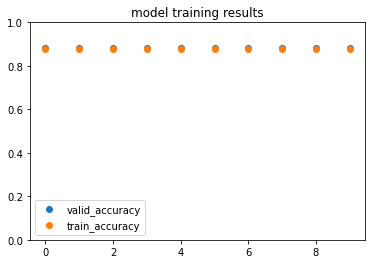

In [29]:
metrics_to_plot = ['valid_accuracy', 'train_accuracy']
fig, ax = plt.subplots(1, 1)
for metric in metrics_to_plot:
    results = get_metric_from_log(source_text, metric)
    ax.scatter(range(len(results)), results)
ax.set_ylim(0, 1)
ax.set_title('model training results')
ax.legend(metrics_to_plot)
plt.show()